In [1]:
import torch
import datasets, networks, sampling, completion, evaluation
import matplotlib.pyplot as plt
from torch import nn

In [2]:
#HYPERPARAMETERS
num_epochs = 30

# TODO Select a optimizer. [ 'adam', 'adamw', 'rmsprop' ]
optimizer_option = 'adamw'

# TODO Select a lr scheduler. [ 'step', 'cosine', 'exponential']
lr_scheduler_option = ''

# TODO Select a batch size.
batch_size = 64

# TODO Select a learning rate.
lr = 0.00005


num_residual = 11
num_kernels = 128

In [3]:
ds = datasets.Dataset('cifar10', batch_size=batch_size)
training_data = ds.get_train_data_loader()
test_data = ds.get_test_data_loader()

# ds.visualize_dataset(training_data)

Files already downloaded and verified


Using device: cuda:0
Epoch:   1/ 30, Batch     1, Loss: 5.6286
Epoch:   1/ 30, Batch   101, Loss: 5.4232
Epoch:   1/ 30, Batch   201, Loss: 5.0143
Epoch:   1/ 30, Batch   301, Loss: 4.7702
Epoch:   1/ 30, Batch   401, Loss: 4.6294
Epoch:   1/ 30, Batch   501, Loss: 4.5351
Epoch:   1/ 30, Batch   601, Loss: 4.4630
Epoch:   1/ 30, Batch   701, Loss: 4.4088
-----------------------------------------
Epoch:   1 took 205.36s
Epoch:   1, Test Loss: 4.3257
-----------------------------------------


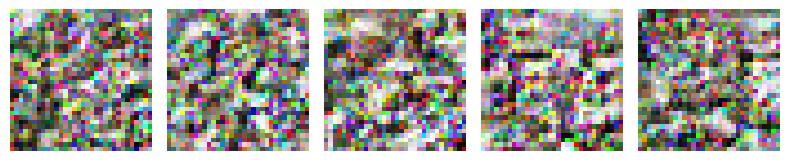

Epoch:   2/ 30, Batch     1, Loss: 4.3486
Epoch:   2/ 30, Batch   101, Loss: 4.3282
Epoch:   2/ 30, Batch   201, Loss: 4.2978
Epoch:   2/ 30, Batch   301, Loss: 4.2611
Epoch:   2/ 30, Batch   401, Loss: 4.2289
Epoch:   2/ 30, Batch   501, Loss: 4.2020
Epoch:   2/ 30, Batch   601, Loss: 4.1787
Epoch:   2/ 30, Batch   701, Loss: 4.1586
-----------------------------------------
Epoch:   2 took 215.43s
Epoch:   2, Test Loss: 4.1131
-----------------------------------------


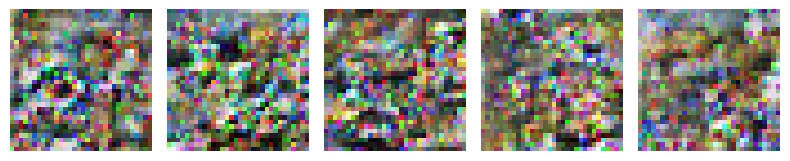

Epoch:   3/ 30, Batch     1, Loss: 4.1631
Epoch:   3/ 30, Batch   101, Loss: 4.1118
Epoch:   3/ 30, Batch   201, Loss: 4.0962
Epoch:   3/ 30, Batch   301, Loss: 4.0775
Epoch:   3/ 30, Batch   401, Loss: 4.0605
Epoch:   3/ 30, Batch   501, Loss: 4.0379
Epoch:   3/ 30, Batch   601, Loss: 4.0346
Epoch:   3/ 30, Batch   701, Loss: 4.0167
-----------------------------------------
Epoch:   3 took 204.62s
Epoch:   3, Test Loss: 3.9518
-----------------------------------------


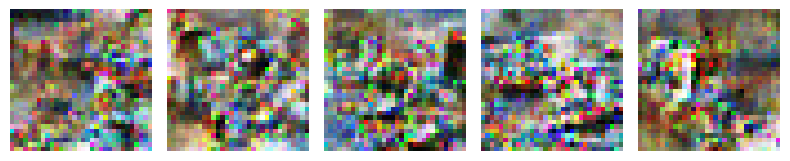

Epoch:   4/ 30, Batch     1, Loss: 3.9794
Epoch:   4/ 30, Batch   101, Loss: 3.9818
Epoch:   4/ 30, Batch   201, Loss: 3.9648
Epoch:   4/ 30, Batch   301, Loss: 3.9534
Epoch:   4/ 30, Batch   401, Loss: 3.9454
Epoch:   4/ 30, Batch   501, Loss: 3.9252
Epoch:   4/ 30, Batch   601, Loss: 3.9169
Epoch:   4/ 30, Batch   701, Loss: 3.9010
-----------------------------------------
Epoch:   4 took 211.34s
Epoch:   4, Test Loss: 3.8553
-----------------------------------------


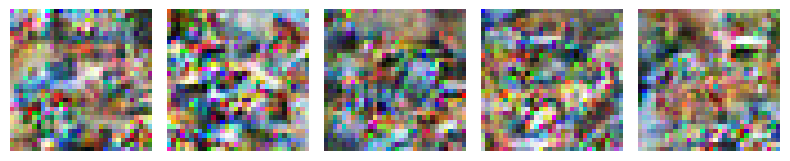

Epoch:   5/ 30, Batch     1, Loss: 3.8785
Epoch:   5/ 30, Batch   101, Loss: 3.8878
Epoch:   5/ 30, Batch   201, Loss: 3.8797
Epoch:   5/ 30, Batch   301, Loss: 3.8721
Epoch:   5/ 30, Batch   401, Loss: 3.8545
Epoch:   5/ 30, Batch   501, Loss: 3.8540
Epoch:   5/ 30, Batch   601, Loss: 3.8358
Epoch:   5/ 30, Batch   701, Loss: 3.8295
-----------------------------------------
Epoch:   5 took 212.25s
Epoch:   5, Test Loss: 3.7811
-----------------------------------------


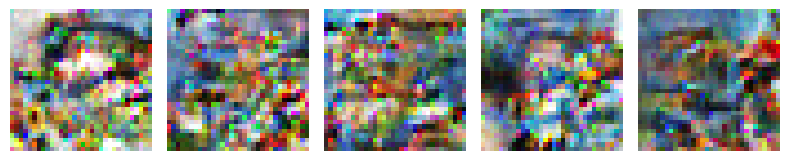

Epoch:   6/ 30, Batch     1, Loss: 3.7943
Epoch:   6/ 30, Batch   101, Loss: 3.8171
Epoch:   6/ 30, Batch   201, Loss: 3.8034
Epoch:   6/ 30, Batch   301, Loss: 3.8025
Epoch:   6/ 30, Batch   401, Loss: 3.7844
Epoch:   6/ 30, Batch   501, Loss: 3.7913
Epoch:   6/ 30, Batch   601, Loss: 3.7756
Epoch:   6/ 30, Batch   701, Loss: 3.7601
-----------------------------------------
Epoch:   6 took 215.25s
Epoch:   6, Test Loss: 3.7608
-----------------------------------------


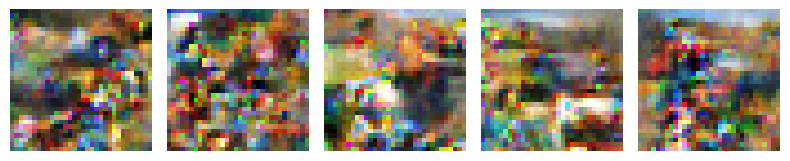

Epoch:   7/ 30, Batch     1, Loss: 3.7141
Epoch:   7/ 30, Batch   101, Loss: 3.7625
Epoch:   7/ 30, Batch   201, Loss: 3.7513
Epoch:   7/ 30, Batch   301, Loss: 3.7498
Epoch:   7/ 30, Batch   401, Loss: 3.7369
Epoch:   7/ 30, Batch   501, Loss: 3.7357
Epoch:   7/ 30, Batch   601, Loss: 3.7217
Epoch:   7/ 30, Batch   701, Loss: 3.7280
-----------------------------------------
Epoch:   7 took 214.78s
Epoch:   7, Test Loss: 3.7070
-----------------------------------------


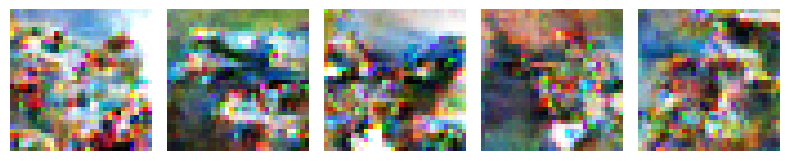

Epoch:   8/ 30, Batch     1, Loss: 3.7057
Epoch:   8/ 30, Batch   101, Loss: 3.7114
Epoch:   8/ 30, Batch   201, Loss: 3.7118
Epoch:   8/ 30, Batch   301, Loss: 3.6965
Epoch:   8/ 30, Batch   401, Loss: 3.6955
Epoch:   8/ 30, Batch   501, Loss: 3.6950
Epoch:   8/ 30, Batch   601, Loss: 3.6924
Epoch:   8/ 30, Batch   701, Loss: 3.6884
-----------------------------------------
Epoch:   8 took 209.83s
Epoch:   8, Test Loss: 3.6428
-----------------------------------------


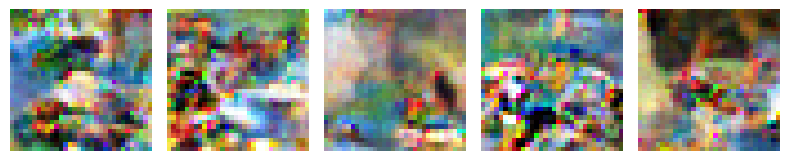

Epoch:   9/ 30, Batch     1, Loss: 3.6685
Epoch:   9/ 30, Batch   101, Loss: 3.6764
Epoch:   9/ 30, Batch   201, Loss: 3.6715
Epoch:   9/ 30, Batch   301, Loss: 3.6699
Epoch:   9/ 30, Batch   401, Loss: 3.6707
Epoch:   9/ 30, Batch   501, Loss: 3.6629
Epoch:   9/ 30, Batch   601, Loss: 3.6595
Epoch:   9/ 30, Batch   701, Loss: 3.6572
-----------------------------------------
Epoch:   9 took 216.39s
Epoch:   9, Test Loss: 3.6570
-----------------------------------------


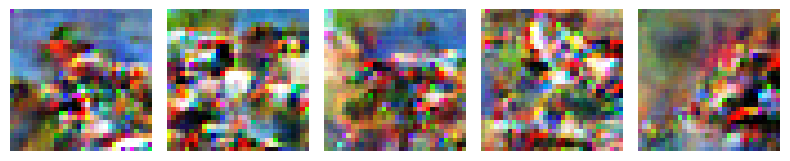

Epoch:  10/ 30, Batch     1, Loss: 3.6038
Epoch:  10/ 30, Batch   101, Loss: 3.6446
Epoch:  10/ 30, Batch   201, Loss: 3.6489
Epoch:  10/ 30, Batch   301, Loss: 3.6428
Epoch:  10/ 30, Batch   401, Loss: 3.6516
Epoch:  10/ 30, Batch   501, Loss: 3.6389
Epoch:  10/ 30, Batch   601, Loss: 3.6413
Epoch:  10/ 30, Batch   701, Loss: 3.6329
-----------------------------------------
Epoch:  10 took 224.16s
Epoch:  10, Test Loss: 3.6173
-----------------------------------------


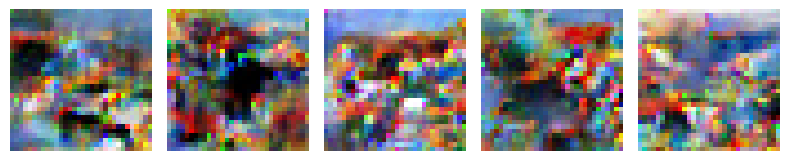

Epoch:  11/ 30, Batch     1, Loss: 3.6219
Epoch:  11/ 30, Batch   101, Loss: 3.6197
Epoch:  11/ 30, Batch   201, Loss: 3.6248
Epoch:  11/ 30, Batch   301, Loss: 3.6244
Epoch:  11/ 30, Batch   401, Loss: 3.6179
Epoch:  11/ 30, Batch   501, Loss: 3.6246
Epoch:  11/ 30, Batch   601, Loss: 3.6190
Epoch:  11/ 30, Batch   701, Loss: 3.6070
-----------------------------------------
Epoch:  11 took 212.18s


In [4]:
# Training
import time
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
from torch.optim import Adam, AdamW, RMSprop, SGD 

PixelCNN = networks.PixelCNN(num_kernels=num_kernels, num_residual=num_residual)
# Select device
# if torch.cuda.is_available():
#   device = torch.device('cuda:0')
# else:
#   device = torch.device('cpu')
device = torch.device('cuda:0')
print(f'Using device: {device}')
print('=========================================')

PixelCNN.to(device)

learning_rates = []
train_loss_curve = []
test_loss_curve = []
train_loss_epochs = []
test_loss_epochs = []
optimizer = None

# Select optimizer
if optimizer_option == "adam":
  optimizer = torch.optim.Adam(PixelCNN.parameters(), lr)
  
elif optimizer_option == "adamw":
  optimizer = torch.optim.AdamW(PixelCNN.parameters(), lr)
  
elif optimizer_option == "rmsprop":
  optimizer = torch.optim.RMSprop(PixelCNN.parameters(), lr)
  
else:
  optimizer = torch.optim.SGD(PixelCNN.parameters(), lr, momentum=0.9)  


#Select scheduler
scheduler = None
if lr_scheduler_option == 'step':
    scheduler = StepLR(optimizer, step_size=2, gamma=0.9)
    
elif lr_scheduler_option == 'exponential':
    scheduler = ExponentialLR(optimizer, gamma=0.9)
    
elif lr_scheduler_option == 'cosine':
    scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0001)

overall_start_time = time.time()

# training loop
for epoch in range(num_epochs):

  epoch_start_time = time.time()
  # Switch to training mode.
  PixelCNN.train()

  losses = []
  batch_idx = 0

  for images, labels in training_data:

    images = images.to(device)
    output = PixelCNN(images)
    # print(output.shape)
    images = images.view(-1)
    # images = images.permute(0, 2, 3, 1).contiguous().view(-1)
    # print(images.shape)
    output = torch.reshape(output, (batch_size, 256, 3, 32, 32))
    output = output.permute(0,2,3,4,1).contiguous().view(-1, 256)

    # output = nn.functional.softmax(output, dim=1)
    # output = torch.argmax(output, dim=1)

    # print(output)
    images = images*255
    # print(images.long())

    loss = nn.functional.cross_entropy(output, images.long())
    loss.backward()
    torch.nn.utils.clip_grad_norm_(PixelCNN.parameters(), 1)
    # torch.nn.utils.clip_grad_norm_(PixelCNN.parameters(), 1)
    optimizer.step()
    for param_group in optimizer.param_groups:
      learning_rates.append(param_group['lr'])
    optimizer.zero_grad()


    losses.append(loss.detach().clone())

    if batch_idx % 100 == 0:
      average_loss = torch.stack(losses).mean().item()
      train_loss_curve.append(average_loss)
      train_loss_epochs.append(epoch + 1)
      losses = []
      print(f'Epoch: {epoch + 1:3d}/{num_epochs:3d}, Batch {batch_idx + 1:5d}, Loss: {average_loss:.4f}')
    batch_idx += 1

  # scheduler.step()
  epoch_end_time = time.time()
  print('-----------------------------------------')
  print(f'Epoch: {epoch + 1:3d} took {epoch_end_time - epoch_start_time:.2f}s')
  test_loss = evaluation.evaluate(model=PixelCNN, test_data_loader=test_data, device=device, batch_size=batch_size)
  test_loss_curve.append(test_loss)
  test_loss_epochs.append(epoch + 1)
  print(f'Epoch: {epoch + 1:3d}, Test Loss: {test_loss:.4f}')
  print('-----------------------------------------')
  

  samples = sampling.sample(PixelCNN, num_samples=5)
  sampling.save_samples(samples)
  

overall_end_time = time.time()
print('=========================================')
print(f'Training took {overall_end_time - overall_start_time:.2f}s')

# Loss Curve Plot
plt.figure(figsize=(10, 5))
plt.plot(train_loss_epochs, train_loss_curve, label='Train Loss')
plt.scatter(test_loss_epochs, test_loss_curve, color='red', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Learning Rate Plot
num_batches = len(training_data)
learning_rates_res = [sum(learning_rates[i * num_batches:(i + 1) * num_batches]) / num_batches for i in range(num_epochs)]
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), learning_rates_res)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Time')
plt.show()